In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, stats
from scipy.fftpack import fft, ifft, fftfreq
import pickle

Here we will attempt to extract the long-term trend of uptake and CO2 concentration timeseries by applying a low pass filter to the original annual (and monthly) timeseries to remove the interannual time scales and shorter.

# GCP data

In [2]:
df = pd.read_csv("./../../../output/inversions/raw/output_GCP.csv", index_col="Year")
x = df.index.values
y_land = df["land"].values

In [3]:
freqs, X = signal.welch(y_land)

C:\Users\Ross\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1969: UserWarning: nperseg = 256 is greater than input length  = 60, using nperseg = 60
  .format(nperseg, input_length))


Text(0, 0.5, 'Spectral Variance ((GtC/yr)$^2$.yr)')

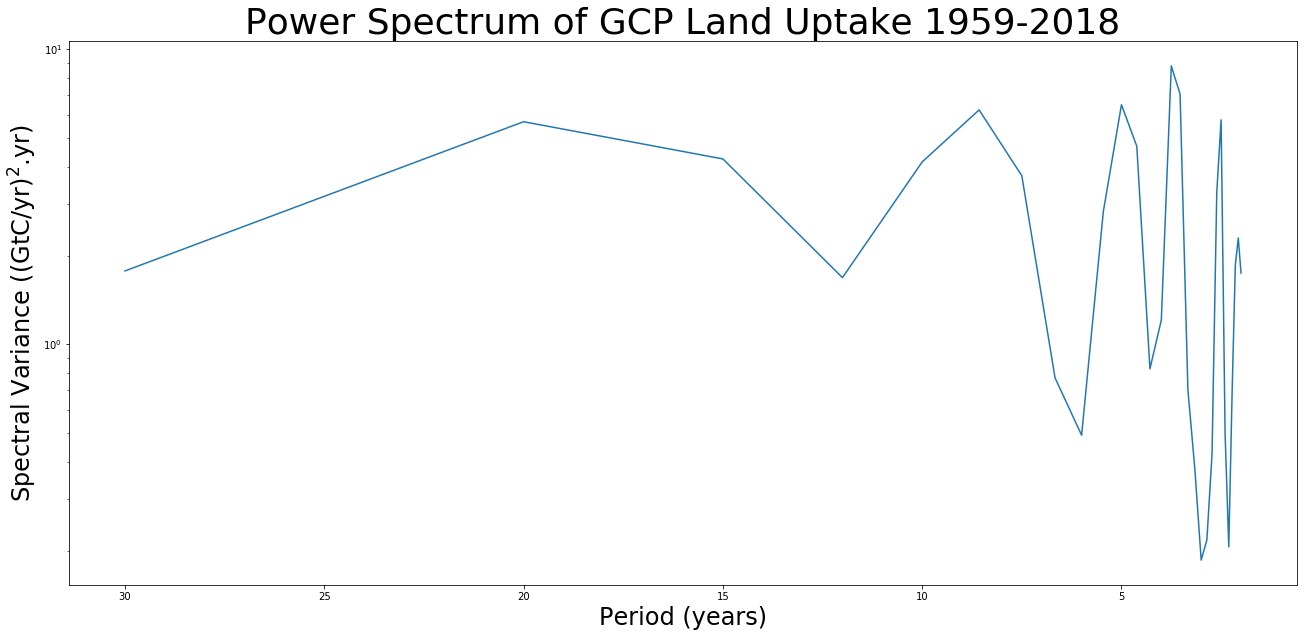

In [4]:
plt.figure(figsize=(22,10))

plt.semilogy(1/freqs[2:], X[2:])

plt.title("Power Spectrum of GCP Land Uptake 1959-2018", fontsize=36)
plt.gca().invert_xaxis()
plt.xlabel("Period (years)", fontsize=24)
plt.ylabel("Spectral Variance ((GtC/yr)$^2$.yr)", fontsize=24)
# plt.ylim([10e-5, 10e1])

In [5]:
pd.DataFrame({"Period (yrs)": 1/freqs, "Spectral Variance": X}, index=freqs)

C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


,Period (yrs),Spectral Variance
0.000000,inf,1.394261
0.016667,60.000000,9.003595
0.033333,30.000000,1.775211
0.050000,20.000000,5.684921
0.066667,15.000000,4.252835
0.083333,12.000000,1.684954
0.100000,10.000000,4.154424
0.116667,8.571429,6.233548
0.133333,7.500000,3.729661
0.150000,6.666667,0.770890


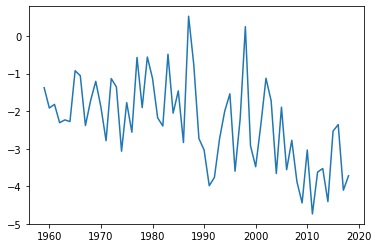

In [6]:
plt.plot(x, y_land)

Text(0, 0.5, 'Spectral Variance ((GtC/yr)$^2$.yr)')

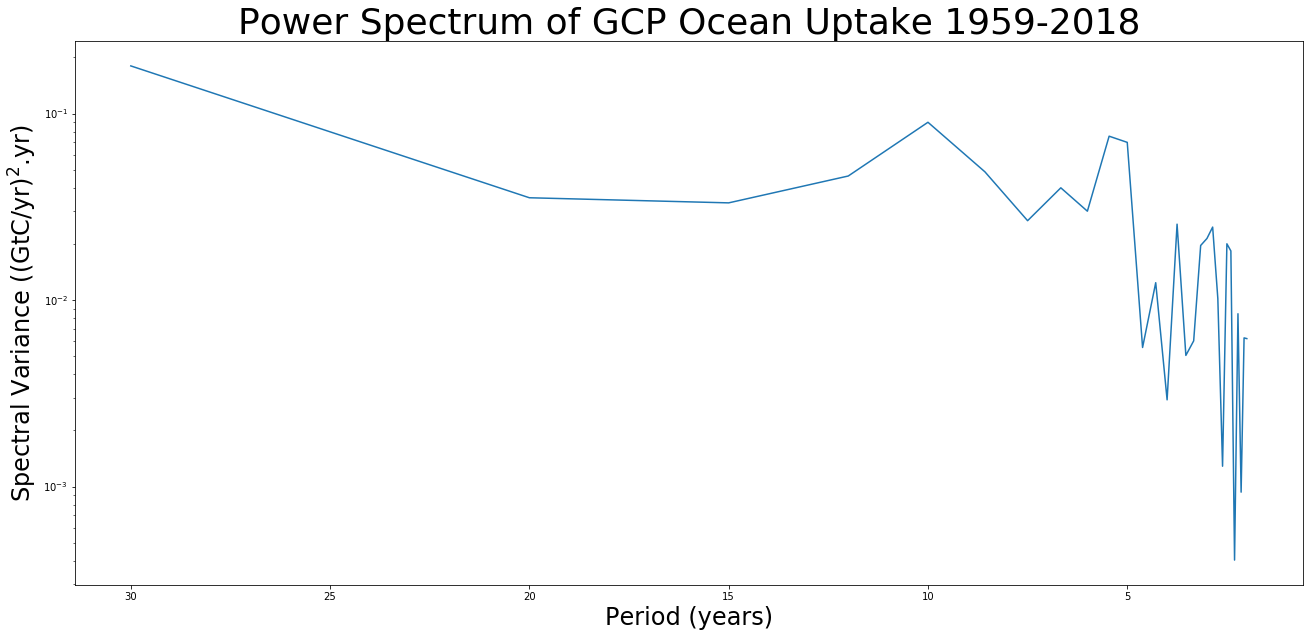

In [7]:
y_ocean = df["ocean"].values
freqs_ocean, X_ocean = signal.welch(y_ocean)


plt.figure(figsize=(22,10))

plt.semilogy(1/freqs_ocean[2:], X_ocean[2:])

plt.title("Power Spectrum of GCP Ocean Uptake 1959-2018", fontsize=36)
plt.gca().invert_xaxis()
plt.xlabel("Period (years)", fontsize=24)
plt.ylabel("Spectral Variance ((GtC/yr)$^2$.yr)", fontsize=24)
# plt.ylim([10e-5, 10e1])

In [8]:
pd.DataFrame({"Period (yrs)": 1/freqs_ocean, "Spectral Variance": X_ocean}, index=freqs_ocean)

C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


,Period (yrs),Spectral Variance
0.000000,inf,0.052563
0.016667,60.000000,2.688065
0.033333,30.000000,0.179960
0.050000,20.000000,0.035339
0.066667,15.000000,0.033179
0.083333,12.000000,0.046222
0.100000,10.000000,0.089738
0.116667,8.571429,0.048685
0.133333,7.500000,0.026625
0.150000,6.666667,0.039954


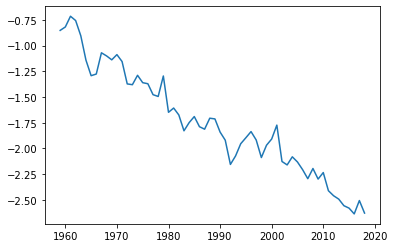

In [9]:
plt.plot(x,y_ocean)

## Low pass filter - GCP

do 10 year periods and higher (or 1/10yr freq. and lower).

In [10]:
# Function for band pass filtering

def bandpass(x, fc, fs=1, order=5, btype="low", deseasonalise_first=False):
    """ Filters a dataset (either lowpass, highpass or bandpass) by bandpass using scipy.signal.butter.
    
    Parameters:
    -----------
    x: dataset
    fc: cut-off frequency or frequencies.
    fs: sample frequency of x.
    order: order of the filter. Defaults to 5.
    btype: options are low, high and band.
    deseasonalise_first: Defaults to False. Option to deseasonalise timeseries before applying bandpass filter.
    """
    
    if deseasonalise_first:
        mean_list = []
        for i in range(12):
            indices = range(i, len(x)+i, 12)
            sub = x[indices]
            mean_list.append(np.mean(sub))

        s = []
        for i in range(int(len(x)/12)):
            for j in mean_list:
                s.append(j)
        s = np.array(s)

        x = x - (s-np.mean(s))
    
    if btype == "band":
        assert type(fc) == list, "fc must be a list of two values."
        fc = np.array(fc)
    
    w = fc / (fs / 2) # Normalize the frequency.
    b, a = signal.butter(order, w, btype)
    
    return signal.filtfilt(b, a, x)

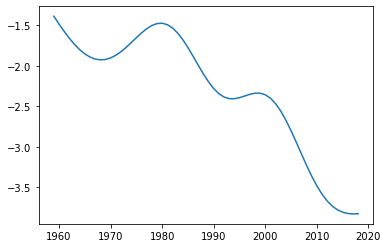

In [11]:
lowpass_land = bandpass(y_land, fc=1/20, btype="low", order=5)
plt.plot(x, lowpass_land)

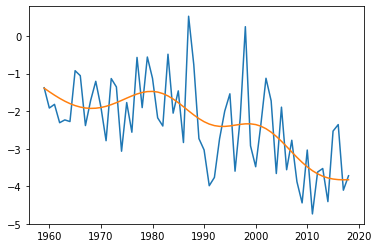

In [12]:
plt.plot(x, y_land)
plt.plot(x, lowpass_land)

In [13]:
pickle.dump(x, open("./GCP_time.pik", "wb"))
pickle.dump(y_land, open("./GCP_land.pik", "wb"))
pickle.dump(lowpass_land, open("./GCP_land_lowpass.pik", "wb"))

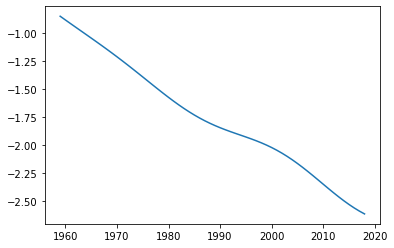

In [14]:
lowpass_ocean = bandpass(y_ocean, fc=1/30, btype="low", order=5)
plt.plot(x, lowpass_ocean)

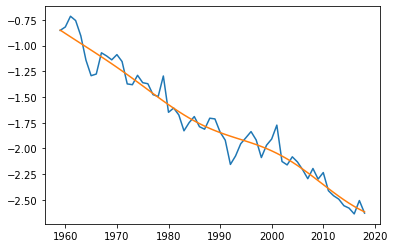

In [15]:
plt.plot(x, y_ocean)
plt.plot(x, lowpass_ocean)

In [16]:
pickle.dump(y_ocean, open("./GCP_ocean.pik", "wb"))
pickle.dump(lowpass_ocean, open("./GCP_ocean_lowpass.pik", "wb"))

# Monthly model data

In [17]:
df_monthly = pickle.load(open("./../../../output/inversions/raw/output_all/JENA_s76_all/spatial.pik", "rb"))

In [18]:
df_monthly.time

<xarray.DataArray 'time' (time: 504)>
array([cftime.Datetime360Day(1976, 1, 16, 0, 0, 0, 0, 0, 16),
       cftime.Datetime360Day(1976, 2, 16, 0, 0, 0, 0, 2, 46),
       cftime.Datetime360Day(1976, 3, 16, 0, 0, 0, 0, 4, 76), ...,
       cftime.Datetime360Day(2017, 10, 16, 0, 0, 0, 0, 1, 286),
       cftime.Datetime360Day(2017, 11, 16, 0, 0, 0, 0, 3, 316),
       cftime.Datetime360Day(2017, 12, 16, 0, 0, 0, 0, 5, 346)], dtype=object)
Coordinates:
  * time     (time) object 1976-01-16 00:00:00 ... 2017-12-16 00:00:00

In [21]:
x_month = np.arange(1976,2018,1./12)
y_month = df_monthly.Earth_Land.values

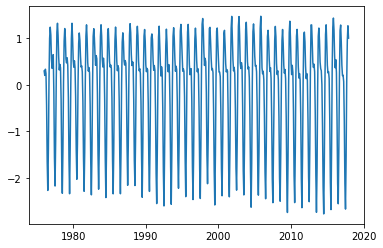

In [22]:
plt.plot(x_month, y_month)

In [23]:
freqs_month, X_month = signal.welch(y_month)

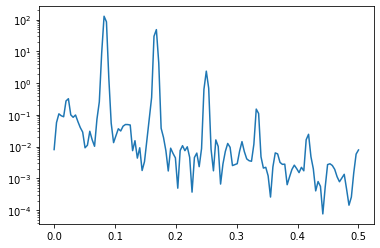

In [24]:
plt.semilogy(freqs_month, X_month)

In [25]:
pd.DataFrame({"Period (months)": 1/freqs_month, "Spectral Variance": X_month}, index=freqs_month).head(60);

C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


Spikes at 6 and 12 month (or half yearly and yearly) periods. This is as we'd expect knowing that their are respiration and photosynthesis periods every year.

In [26]:
def spectral_analysis(x, y, plot="loglog"):
    
    """
    plot options: plot, semilogy, loglog
    """
    
    plt.figure(figsize=(12,9))
    plt.subplot(211)
    plt.plot(x,y)
    
    freqs, spec = signal.welch(y)
    plt.subplot(212)
    
    if plot == "plot":
        plt.plot(freqs, spec)
    elif plot == "semilogy":
        plt.semilogy(freqs, spec)
    elif plot == "loglog":
        plt.loglog(freqs, spec)
    else:
        return "Please input either plot, semilogy or loglog for plot input."
    
    return pd.DataFrame({"Period (months)": 1/freqs, "Spectral Variance": spec}, index=freqs)

C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


,Period (months),Spectral Variance
0.000000,inf,0.008072
0.003906,256.000000,0.057071
0.007812,128.000000,0.107880
0.011719,85.333333,0.093876
0.015625,64.000000,0.087338
...,...,...
0.484375,2.064516,0.000143
0.488281,2.048000,0.000257
0.492188,2.031746,0.001480
0.496094,2.015748,0.005813


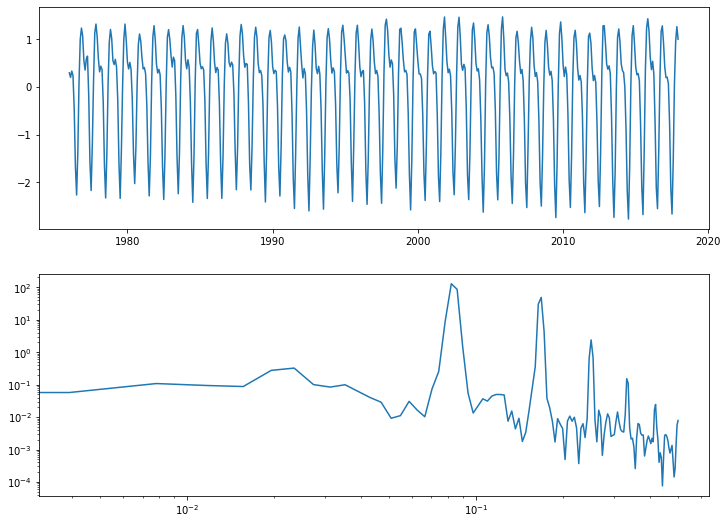

In [27]:
spectral_analysis(x_month, y_month)

In [28]:
def deseasonalise(x, y):
    
    mean_list = []
    for i in range(12):
        indices = range(i, len(y)+i, 12)
        sub = y[indices]
        mean_list.append(np.mean(sub))
    
    s = []
    for i in range(int(len(y)/12)):
        for j in mean_list:
            s.append(j)
    s = np.array(s)
    
    deseasonalised_y = y - (s-np.mean(s))
    
    plt.figure(figsize = (16,9))
    plt.plot(x, deseasonalised_y, label="deseasonalised")
    plt.plot(x, y, label="land")
    plt.legend()
    
    return deseasonalised_y

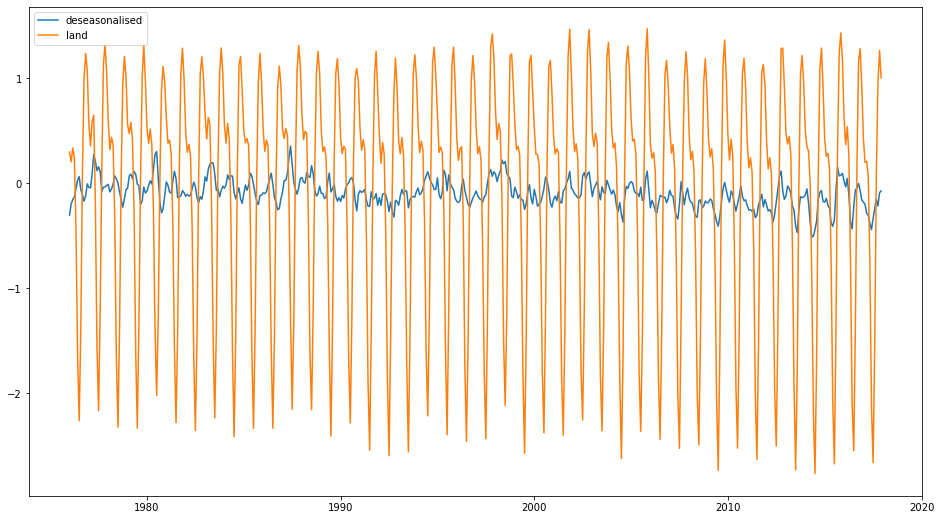

In [29]:
y_des = deseasonalise(x_month, y_month)

C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


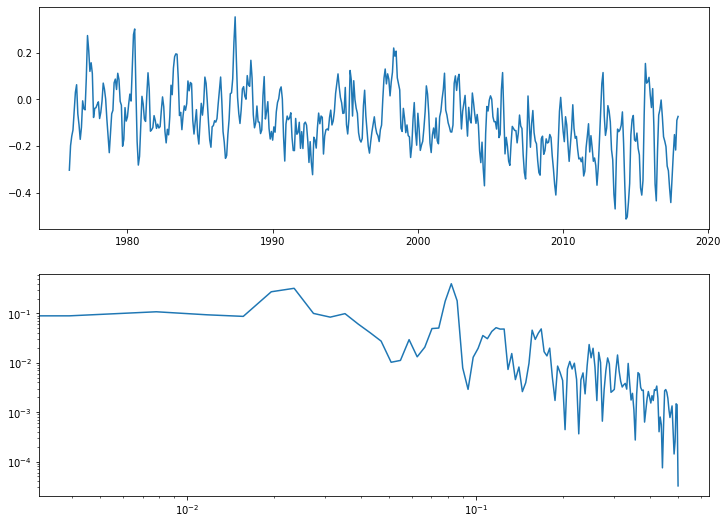

In [30]:
des_sample = spectral_analysis(x_month, y_des)

C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


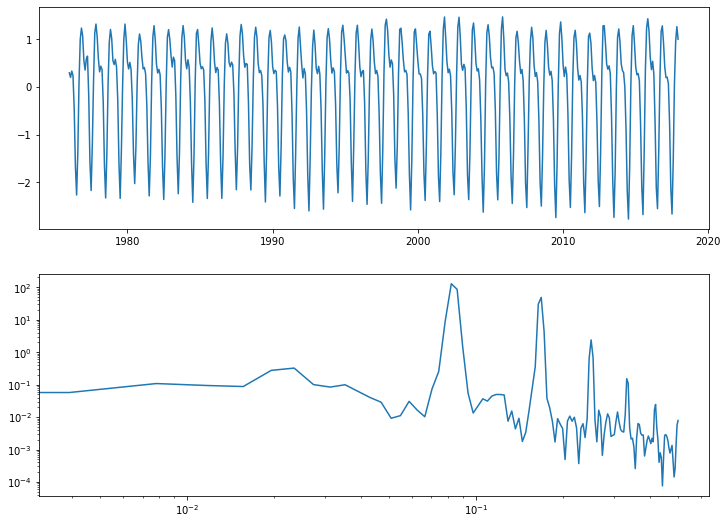

In [31]:
normal_sample = spectral_analysis(x_month, y_month)

C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  after removing the cwd from sys.path.


(1.5079659529627976e-05, 1)

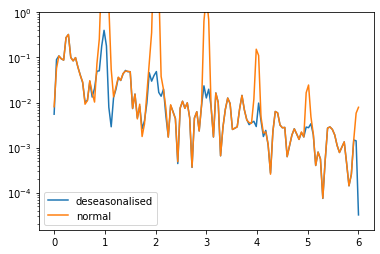

In [32]:
plt.semilogy(12/des_sample["Period (months)"], des_sample["Spectral Variance"], label="deseasonalised")
plt.semilogy(12/normal_sample["Period (months)"], normal_sample["Spectral Variance"], label="normal")
plt.legend()
plt.ylim([0,1])

C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  after removing the cwd from sys.path.


(1.4568288532849497e-05, 1)

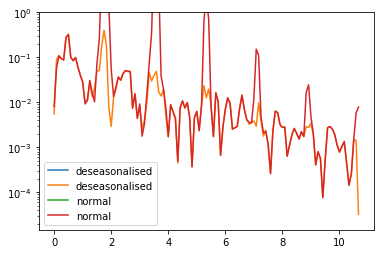

In [33]:
plt.semilogy(np.arange(len(des_sample))/12, des_sample, label="deseasonalised")
plt.semilogy(np.arange(len(normal_sample))/12, normal_sample, label="normal")
plt.legend()
plt.ylim([0,1])

In [43]:
1/(12*freqs_month[np.where((normal_sample > 1))[0]])

C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


array([        inf, 21.33333333, 10.66666667,  7.11111111,  5.33333333,
        4.26666667,  3.55555556,  3.04761905,  2.66666667,  2.37037037,
        2.13333333,  1.93939394,  1.77777778,  1.64102564,  1.52380952,
        1.42222222,  1.33333333,  1.25490196,  1.18518519,  1.12280702,
        1.06666667,  1.06666667,  1.01587302,  1.01587302,  0.96969697,
        0.96969697,  0.92753623,  0.92753623,  0.88888889,  0.85333333,
        0.82051282,  0.79012346,  0.76190476,  0.73563218,  0.71111111,
        0.68817204,  0.66666667,  0.64646465,  0.62745098,  0.60952381,
        0.59259259,  0.57657658,  0.56140351,  0.54700855,  0.53333333,
        0.5203252 ,  0.50793651,  0.50793651,  0.49612403,  0.49612403,
        0.48484848,  0.48484848,  0.47407407,  0.46376812,  0.45390071,
        0.44444444,  0.43537415,  0.42666667,  0.41830065,  0.41025641,
        0.40251572,  0.39506173,  0.38787879,  0.38095238,  0.37426901,
        0.36781609,  0.36158192,  0.35555556,  0.34972678,  0.34

In [46]:
1/(12*freqs_month[np.where((normal_sample > 0.2) & (normal_sample < 0.7))[0]])

array([4.26666667, 3.55555556, 1.12280702, 0.5203252 , 0.33862434,
       0.32820513])

Spikes at 1 year, 1/2 year and 4 months. They are removed well with the current deseasonalisation method. Other frequencies below 1/year are not removed, however, meaning that there is still some variance. Low pass filtering could remove all frequencies rather than just the 3 spikes. This may not be necessary.

Local spike at around 3.5-4 year periods. Most likely attributed to the interannual variability of uptake, which is effectively the rough cycle of ENSO.

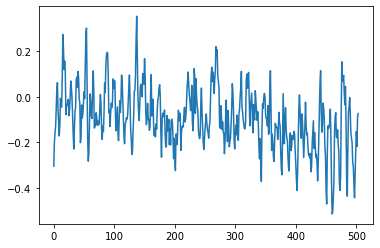

In [47]:
plt.plot(y_des)

## Band pass filter - model

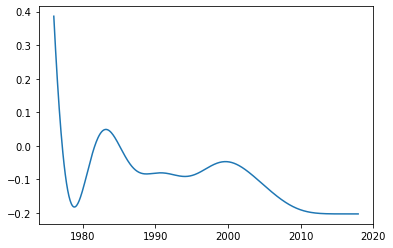

In [48]:
pass_y_month = bandpass(y_month, fc=1/(9*12), btype="low", order=9, deseasonalise_first=False)
plt.plot(x_month, pass_y_month)

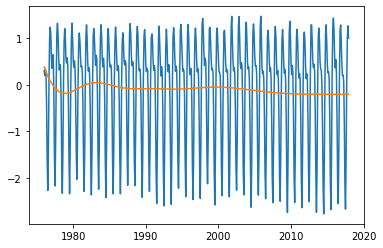

In [49]:
plt.plot(x_month, y_month)
plt.plot(x_month, pass_y_month)

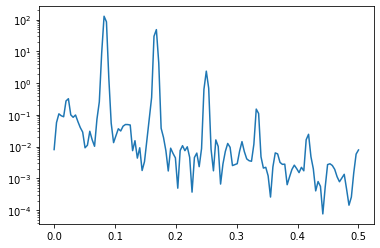

In [50]:
plt.semilogy(signal.welch(y_month)[0], signal.welch(y_month)[1])

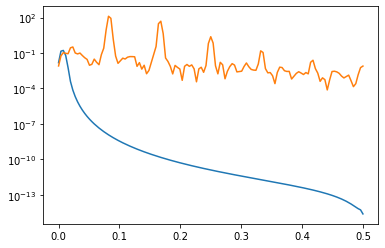

In [51]:
plt.semilogy(signal.welch(pass_y_month)[0], signal.welch(pass_y_month)[1])
plt.semilogy(signal.welch(y_month)[0], signal.welch(y_month)[1])

Deseasonalisation still does a better job at removing the seasonal/monthly frequencies. Pass filtering can be applied to the deseasonalised timeseries for further analysis.

In [52]:
pass_y_des = bandpass(y_des, fc=1/(1*12), btype="low", order=5)

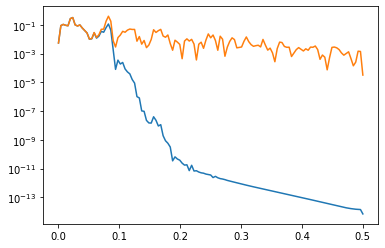

In [53]:
plt.semilogy(signal.welch(pass_y_des)[0], signal.welch(pass_y_des)[1])
plt.semilogy(signal.welch(y_des)[0], signal.welch(y_des)[1])

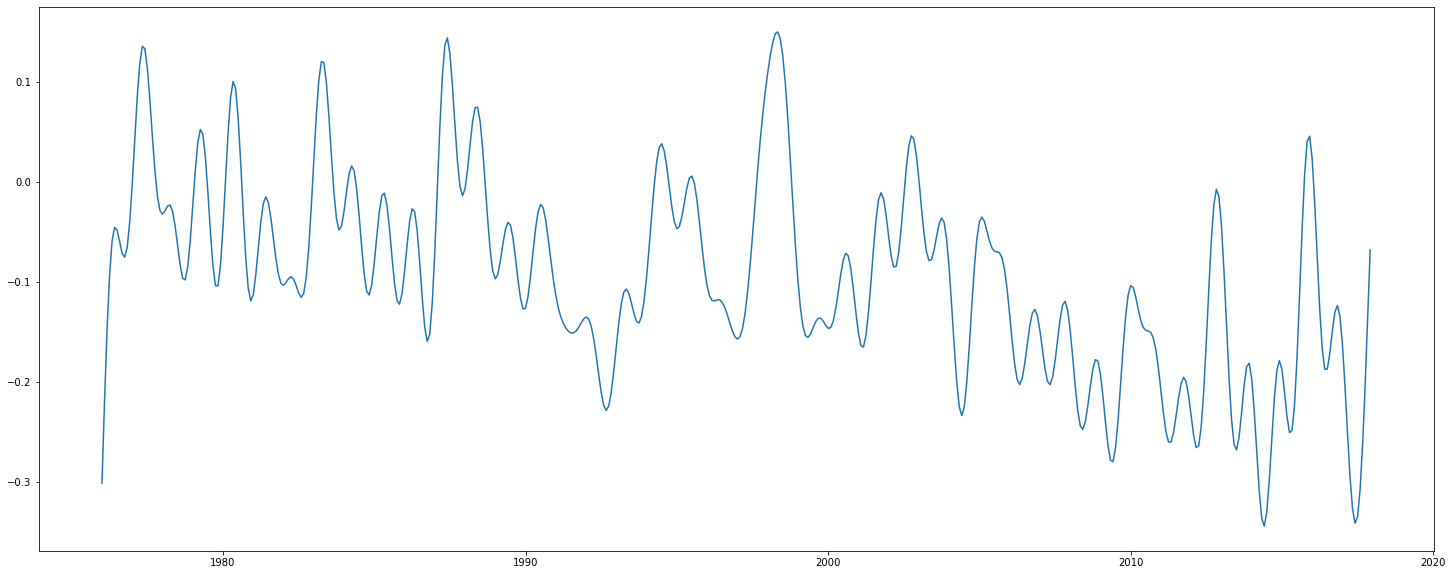

In [54]:
plt.figure(figsize=(25,10))
plt.plot(x_month, pass_y_des)

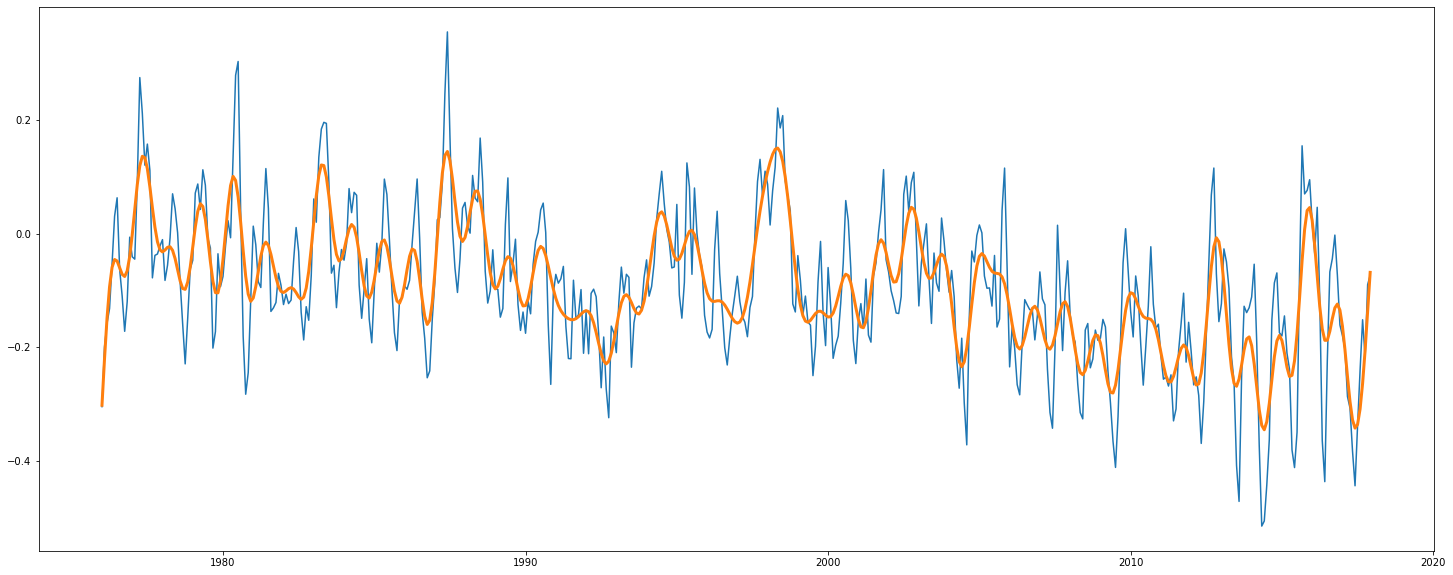

In [55]:
plt.figure(figsize=(25,10))
plt.plot(x_month, y_des)
plt.plot(x_month, pass_y_des, linewidth=3)

# INVF Integration

In [57]:
import sys
sys.path.append("./../../../scripts/core")
import inv_flux as invf

In [58]:
from importlib import reload

In [59]:
reload(invf)

<module 'inv_flux' from './../../../scripts/core\\inv_flux.py'>

In [60]:
JENA_s76 = invf.Analysis(df_monthly)

./../../../scripts/core\inv_flux.py:292: RuntimeWarning: divide by zero encountered in true_divide
  return pd.DataFrame({f"Period{period}": 1/freqs, f"Spectral Variance {unit}": spec}, index=freqs)


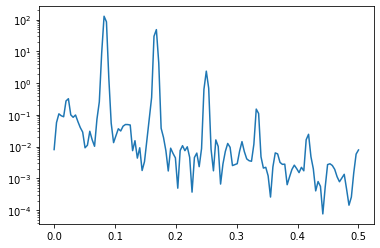

In [61]:
plt.semilogy(1/(JENA_s76.psd("Earth_Land").iloc[:,0]), JENA_s76.psd("Earth_Land").iloc[:,1])

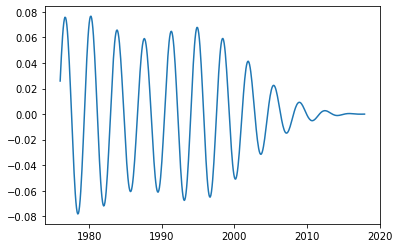

In [62]:
output = JENA_s76.bandpass("Earth_Land", fc=[1/(4*12), 1/(3*12)], btype="band", deseasonalise_first=True)
plt.plot(x_month, output)

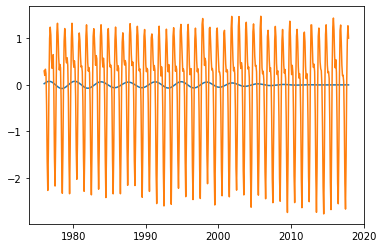

In [63]:
plt.plot(x_month, output)
plt.plot(x_month, JENA_s76.data.Earth_Land.values)